In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [0]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [0]:
IS_LINUX = False
from sys import platform
if platform == "linux" or platform == "linux2":
  IS_LINUX = True

In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
if IS_LINUX:
    !pip install tensorflow-gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(device = gpus[0], enable = True)


In [3]:
if tf.test.is_gpu_available():
  print("GPU OK")
else:
  print("GPU NOT OK")

GPU OK


In [4]:
if IS_LINUX:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
if IS_LINUX:
    !ls drive/My\ Drive/'Colab Notebooks'/

'Autoencoder start.ipynb'   file.txt  'First try.ipynb'   Untitled


In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
import matplotlib.pyplot as plt

2.0.0


In [7]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
train_labels_one_hot_encoding = keras.utils.to_categorical(train_labels)
test_labels_one_hot_encoding = keras.utils.to_categorical(test_labels)

train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], -1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], -1)

INPUT_SHAPE = train_images.shape[1:]
INPUT_SHAPE

4423680/4422102 [==============================] - 0s 0us/step


(28, 28, 1)

In [0]:
#preprocess images
train_images = train_images / 255.0

test_images = test_images / 255.0


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
def plotImage(image, title = None):
  plt.figure()
  plt.imshow(image)
  if title is not None:
    plt.title(title)      
  plt.colorbar()
  plt.grid(False)
  plt.gray()
  plt.show()

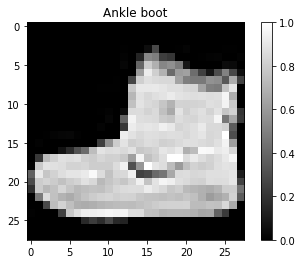

In [11]:
if INPUT_SHAPE[2] == 1:
    plotImage(train_images[0].reshape(INPUT_SHAPE[0], INPUT_SHAPE[1]), class_names[train_labels[0]])
else:
    plotImage(train_images[0], None)


In [0]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Input, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model, Sequential

In [0]:
#loss: 0.0388 - accuracy: 0.9871 - val_loss: 0.4377 - val_accuracy: 0.9305
ENCODED_OUT = 'ENCODED_OUT'
DECODED_OUT = 'DECODED_OUT'
CLASSIFIER_OUT = 'CLASSIFIER_OUT'
#kernel_regularizer = keras.regularizers.l2(0.001)
activation = 'relu'
def get_encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    e = Conv2D(32, (3, 3), activation=activation, padding='same')(input_img) #28 x 28 x 32
    e = BatchNormalization()(e)
    e = Conv2D(32, (3, 3), activation=activation, padding='same')(e)
    e = BatchNormalization()(e)
    e = MaxPooling2D(pool_size=(2, 2))(e) #14 x 14 x 32
    #e = Conv2D(64, (3, 3), activation=activation, padding='same')(e) #14 x 14 x 64
    #e = BatchNormalization()(e)
    e = Conv2D(64, (3, 3), activation=activation, padding='same')(e)
    e = BatchNormalization()(e)
    e = MaxPooling2D(pool_size=(2, 2))(e) #7 x 7 x 64
    e = Conv2D(128, (3, 3), activation=activation, padding='same')(e) #7 x 7 x 128 (small and thick)
    e = BatchNormalization(name = ENCODED_OUT)(e)
    return e

def get_decoder(encoded):    
    #decoder
    d = Conv2D(128, (3, 3), activation=activation, padding='same')(encoded)
    d = BatchNormalization()(d)
    d = Conv2D(64, (3, 3), activation=activation, padding='same')(d) #7 x 7 x 64
    d = BatchNormalization()(d)
    d = Conv2D(64, (3, 3), activation=activation, padding='same')(d)
    d = BatchNormalization()(d)
    d = UpSampling2D((2,2))(d) #14 x 14 x 64
    #d = Conv2D(32, (3, 3), activation=activation, padding='same')(d) # 14 x 14 x 32
    #d = BatchNormalization()(d)
    d = Conv2D(32, (3, 3), activation=activation, padding='same')(d)
    d = BatchNormalization()(d)
    d = UpSampling2D((2,2))(d) # 28 x 28 x 32
    d = Conv2D(INPUT_SHAPE[2], (3, 3), activation='sigmoid',
                     padding='same', 
                     name = DECODED_OUT)(d) # 28 x 28 x 1
    return d

def get_fully_connected(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    den = Dropout(0.3) (den)
    den = Dense(32, activation='relu')(den)
    den = Dropout(0.4) (den)
    out = Dense(len(class_names), activation='softmax', name = CLASSIFIER_OUT)(den)
    return out

In [0]:
#big bud good, makes loss: 0.0253 - accuracy: 0.9912 - val_loss: 0.4275 - val_accuracy: 0.9186
# ENCODED_OUT = 'ENCODED_OUT'
# DECODED_OUT = 'DECODED_OUT'
# CLASSIFIER_OUT = 'CLASSIFIER_OUT'
# #kernel_regularizer = keras.regularizers.l2(0.001)
# activation = 'relu'
# def get_encoder(input_img):
#     #encoder
#     #input = 28 x 28 x 1 (wide and thin)
#     e = Conv2D(32, (3, 3), activation=activation, padding='same')(input_img) #28 x 28 x 32
#     e = BatchNormalization()(e)
#     e = Conv2D(32, (3, 3), activation=activation, padding='same')(e)
#     e = BatchNormalization()(e)
#     e = MaxPooling2D(pool_size=(2, 2))(e) #14 x 14 x 32
#     e = Conv2D(64, (3, 3), activation=activation, padding='same')(e) #14 x 14 x 64
#     e = BatchNormalization()(e)
#     e = Conv2D(64, (3, 3), activation=activation, padding='same')(e)
#     e = BatchNormalization()(e)
#     e = MaxPooling2D(pool_size=(2, 2))(e) #7 x 7 x 64
#     e = Conv2D(128, (3, 3), activation=activation, padding='same')(e) #7 x 7 x 128 (small and thick)
#     e = BatchNormalization()(e)
#     e = Conv2D(128, (3, 3), activation=activation, padding='same')(e) #7 x 7 x 128 (small and thick)
#     e = BatchNormalization()(e)
#     e = Conv2D(256, (3, 3), activation=activation, padding='same')(e) #7 x 7 x 128 (small and thick)
#     e = BatchNormalization()(e)
#     e = Conv2D(256, (3, 3), activation=activation, padding='same')(e) #7 x 7 x 128 (small and thick)
#     e = BatchNormalization(name = ENCODED_OUT)(e)
    
#     return e

# def get_decoder(encoded):    
#     #decoder
#     d = Conv2D(128, (3, 3), activation=activation, padding='same')(encoded)
#     d = BatchNormalization()(d)
#     d = Conv2D(128, (3, 3), activation=activation, padding='same')(d) #7 x 7 x 64
#     d = BatchNormalization()(d)
#     d = Conv2D(64, (3, 3), activation=activation, padding='same')(d) #7 x 7 x 64
#     d = BatchNormalization()(d)
#     d = Conv2D(64, (3, 3), activation=activation, padding='same')(d)
#     d = BatchNormalization()(d)
#     d = UpSampling2D((2,2))(d) #14 x 14 x 64
#     d = Conv2D(32, (3, 3), activation=activation, padding='same')(d) # 14 x 14 x 32
#     d = BatchNormalization()(d)
#     d = Conv2D(32, (3, 3), activation=activation, padding='same')(d)
#     d = BatchNormalization()(d)
#     d = UpSampling2D((2,2))(d) # 28 x 28 x 32
#     d = Conv2D(INPUT_SHAPE[2], (3, 3), activation='sigmoid',
#                      padding='same', 
#                      name = DECODED_OUT)(d) # 28 x 28 x 1
#     return d

# def get_fully_connected(enco):
#     flat = Flatten()(enco)
#     den = Dense(128, activation='relu')(flat)
#     #den = Dropout(0.3) (den)
#     #den = Dense(32, activation='relu')(den)
#     #den = Dropout(0.4) (den)
#     out = Dense(len(class_names), activation='softmax', name = CLASSIFIER_OUT)(den)
#     return out

In [0]:
input_shape = Input(shape = train_images.shape[1:], name = 'INPUT_SHAPE')
encoder = Model(inputs = input_shape, outputs = get_encoder(input_shape), name = 'ENCODER')
encoder_output_shape = Input( shape = encoder.output.shape[1:], name = 'DECODER_INPUT')
decoder = Model(inputs = encoder_output_shape, outputs = get_decoder(encoder_output_shape), name = 'DECODER')
classifier_head = Model(inputs = encoder_output_shape, outputs =get_fully_connected(encoder_output_shape), name = 'CLASSIFIER_HEAD')
autoencoder = Sequential([encoder, decoder], name = DECODED_OUT)
classifier = Sequential([encoder, classifier_head], name = CLASSIFIER_OUT)
auto_classifier = Model(inputs = input_shape,outputs = [autoencoder(input_shape), classifier(input_shape)], name = 'auto_classifier')

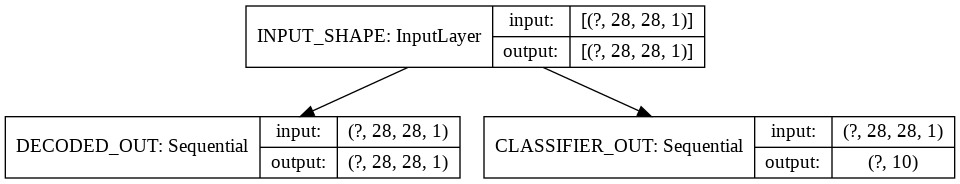

In [17]:
from keras.utils import plot_model
keras.utils.plot_model(auto_classifier, show_shapes=True, to_file = 'model_combined.png')
# keras.utils.plot_model(decoder, show_shapes=True, to_file = 'model_combined.png')
#auto_classifier.summary()

In [18]:
decoder.layers[ - 1] == auto_classifier.layers[1].layers[-1].layers[-1]

True

In [0]:
#Functional way
input_shape = Input(shape = train_images.shape[1:], name = 'INPUT_SHAPE')
encoder = get_encoder(input_shape)
decoder_output = get_decoder(encoder)
autoencoder = Model(input_shape, decoder_output)
fully_connected_output = get_fully_connected(encoder)
classifier = Model(input_shape, fully_connected_output)
auto_classifier = Model(inputs = input_shape, outputs = [autoencoder.outputs, fully_connected_output])



In [0]:
autoencoder.compile(loss = keras.losses.binary_crossentropy, optimizer = keras.optimizers.RMSprop())
classifier.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(), metrics=['accuracy'])
auto_classifier.compile(
    loss = {DECODED_OUT: keras.losses.binary_crossentropy, CLASSIFIER_OUT: keras.losses.categorical_crossentropy},
     loss_weights = {DECODED_OUT: 1.0, CLASSIFIER_OUT: 2.0},
      optimizers = {DECODED_OUT: keras.optimizers.RMSprop() , CLASSIFIER_OUT: keras.optimizers.RMSprop()},
       metrics=["accuracy"]
       )
def set_autoencoder_trainable(value):
    for layer in autoencoder.layers:
        layer.trainable = value

In [0]:
autoencoder.summary()

In [0]:
epochs = 2
#print("Epoch {}".format(epoch))
# print("AutoClassifier")
# historyAutoClassifier = auto_classifier.fit(x = train_images, y = {'DECODED_OUT' : train_images, 'CLASSIFIER_OUT': train_labels_one_hot_encoding } , batch_size=128, epochs= epochs, verbose= 1)
# print("Autoencoder")
# set_autoencoder_trainable(True)
# historyAutoencoder = autoencoder.fit(x = train_images, y = train_images, batch_size=128, epochs= epochs)
#set_autoencoder_trainable(False)
print("Classifier")
historyClassifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=epochs, validation_data= (test_images, test_labels_one_hot_encoding) )


  

Classifier
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 15s 257us/sample - loss: 0.6478 - accuracy: 0.7850 - val_loss: 0.5046 - val_accuracy: 0.8164s - loss: 0.7350 - accura - ETA - ETA: 3s - loss: 0.6972 - accuracy: 0.76 - ETA: 2s - loss: 0.6963 - accu - ETA: 2s - loss: 0.6849  - ETA: 0s - loss: 0.6483 - accuracy: 0.78
Epoch 2/2
60000/60000 [==============================] - 13s 210us/sample - loss: 0.3763 - accuracy: 0.8757 - val_loss: 0.2769 - val_accuracy: 0.9042A: 6s - loss: 0.4004 -  - ETA: 5s - loss: 0.3963  - ETA: 0s -


In [28]:
from functools import wraps
import json
import codecs

def convert_dictionary(dictionary):
    new_hist = {}
    for key in list(dictionary.keys()):
        if type(dictionary[key]) == np.ndarray:
            new_hist[key] = dictionary[key].tolist()
        elif type(dictionary[key]) == list:
           if  type(dictionary[key][0]) in (np.float64, np.float32):
               new_hist[key] = list(map(float, dictionary[key]))
           else:
               new_hist[key] = dictionary[key] 
        else:
           if type(dictionary[key]) in (np.int32, np.int64):
              new_hist[key] = int(dictionary[key])
           else: 
               new_hist[key] = dictionary[key]          
    return new_hist

def serialize_history(history, file):
    json.dump(convert_dictionary(history.params), file)
    file.write('\n')
    json.dump(convert_dictionary(history.history), file)
    file.write('\n')

def logit(logfile='model_default_log.json'):
    def logging_decorator(func):
        @wraps(func)
        def wrapped_function(*args, **kwargs):
            print('fungujem')
            history = func(*args, **kwargs)
            print(history.history)
            model_to_json = history.model.to_json(indent = 4)
#             # Open the logfile and append
            with codecs.open(logfile, 'a', encoding='utf-8') as opened_file:
                # Now we log to the specified logfile
                params_dict = convert_dictionary(history.params)
                history_dict = convert_dictionary(history.history)
                result_dict = {'model' : json.loads(model_to_json), "params": params_dict, "training_history": history_dict }
                json.dump(result_dict, opened_file)
                print("zapisane")
            return history
        return wrapped_function
    return logging_decorator
classifier.to_json

@logit()
def trainClassifier(batch_size=128):
    return classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=epochs, validation_data= (test_images, test_labels_one_hot_encoding))
Model.fit = classifier.fit = logit() (Model.fit())
classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=1, validation_data= (test_images, test_labels_one_hot_encoding))


fungujem


ValueError: ignored

In [0]:
import pickle 
pickle.dump(history.params)

In [0]:
from keras.utils import plot_model
keras.utils.plot_model(auto_classifier, show_shapes=True, to_file = 'model_combined.png')

In [0]:
historyAutoClassifier.history['loss']

In [0]:
def make_batches(to_batch, batch_size = 128):
    return [to_batch[i * batch_size:(i + 1) * batch_size] for i in range((len(to_batch) + batch_size - 1) // batch_size )]

batch_size = 128
to_batch = tf.data.Dataset.from_tensor_slices((train_images, keras.utils.to_categorical(train_labels, 10) ))
train_batched = to_batch.batch(batch_size)

In [0]:

set_autoencoder_trainable(False)
len(classifier.trainable_variables)

In [0]:
epochs = 10
for epoch in range(epochs):
    print("Epoch: {}", epoch)
    for step, (images, labels) in enumerate(train_batched):
        set_autoencoder_trainable(True)
        with tf.GradientTape() as tape:
          prediction = autoencoder(images)
          loss_autoencoder = autoencoder.loss(images, prediction)
          gradients = tape.gradient(loss_autoencoder, autoencoder.trainable_variables)
          autoencoder.optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))  
        set_autoencoder_trainable(False)
        with tf.GradientTape() as tape:
          predict_class = classifier(images)
          loss_classifier = classifier.loss(labels, predict_class)  
#           classiefier_trainable = classifier_head.trainable_variables
          classiefier_trainable = classifier.trainable_variables
          gradients = tape.gradient(loss_classifier, classiefier_trainable)
          classifier.optimizer.apply_gradients(zip(gradients  ,classiefier_trainable) ) 
          if step % 10 == 0:
              print("Step: {}, loss autoencoder: {}, loss classifier: {}".format(step, loss_autoencoder.numpy().mean(), loss_classifier.numpy().mean()))


In [0]:
for layer in autoencoder.layers:
  layer.trainable = True

In [0]:
for epoch in range(5):
  print("Classifier")
  historyClassifier = classifier.fit(x = train_images, y = train_labels_one_hot_encoding, batch_size=128, epochs=1, validation_data= (test_images, test_labels_one_hot_encoding))

In [0]:
predictions_auto_encoder, predictions_classifier = auto_classifier.predict(test_images)
predictions_classifier = np.argmax(np.round(predictions_classifier),axis=1)
correct = np.where(predictions_classifier==test_labels)[0]
print( "Found {} correct labels".format(len(correct)))

In [0]:
accuracy = historyClassifier.history['accuracy']
val_accuracy = historyClassifier.history['val_accuracy']
loss = historyClassifier.history['loss']
val_loss = historyClassifier.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
predictions.shape

In [0]:

test_eval = classifier.evaluate(test_images, test_labels_one_hot_encoding, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
predicted_classes = classifier.predict(test_images)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes = predicted_classes.astype('uint8')
correct = [predicted_classes[i] == value for i, value in enumerate(test_labels)]
print("Correct: {}".format( correct.count(True)))




In [0]:
len(correct)

In [0]:
predictions.shape

In [0]:
predictions = autoencoder.predict(test_images)
# rand_start = np.random.randint(0, len(predictions) - 10)
# for i in range(rand_start, rand_start + 10):
#   plotImage(predictions[i].reshape(28, 28), "Predictions")
#   plotImage(test_images[i].reshape(28, 28), "Original")


num_images = 5
#np.random.seed(42)
random_test_images = np.random.randint(test_images.shape[0], size=num_images)

decoded_imgs = predictions


plt.figure(figsize=(28, 16))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.title("Original")
    plt.imshow(test_images[image_idx]) #.reshape(28, 28)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # # plot encoded image
    # ax = plt.subplot(3, num_images, num_images + i + 1)
    # plt.imshow(encoded_imgs[image_idx].reshape(8, 4))
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx]) #reshape(28, 28)
    plt.title("Predicted")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:


input1 = layers.Input(shape=(16,))
x1 = Dense(8, activation='relu')(input1)
input2 = Input(shape=(32,))
x2 = layers.Dense(8, activation='relu')(input2)
# equivalent to added = keras.layers.add([x1, x2])
added = layers.Add()([x1, x2])

out = layers.Dense(4)(added)
model = models.Model(inputs=[input1, input2], outputs=out)

In [0]:
model.summary()

In [0]:

tf.keras.utils.plot_model(model, show_shapes=True, to_file = 'model_combined.png')